In [95]:
import sys
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
sys.path.append('logger')
from logger import Logger
from logger_utils import prepare_directories_and_logger

sys.path.append('utils')
from save_and_load import load_checkpoint
import random
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
os.environ["CUDA_LAUNCH_BLOCKING"] = '1'
vocoder = torch.hub.load('descriptinc/melgan-neurips', 'load_melgan')

Using cache found in /home/ericwudayi/.cache/torch/hub/descriptinc_melgan-neurips_master


In [3]:
import importlib
model = importlib.import_module(f'model.vqvc+_multi.vq_model')
model = getattr(model, 'VC_MODEL')
model = (model(in_channel=80,channel=512,n_embed=64)).cuda()
opt = optim.Adam(model.parameters())
model, opt, iteration = load_checkpoint(f'checkpoint/vqvc+_multi_n64_ch512_train_simple_normalize_multi/gen', model, opt)

Loading checkpoint 'checkpoint/vqvc+_multi_n64_ch512_train_simple_normalize_multi/gen'
Loaded checkpoint 'checkpoint/vqvc+_multi_n64_ch512_train_simple_normalize_multi/gen' from iteration 170574


In [17]:
audio_dir = '/home/ericwudayi/nas189/homes/ericwudayi/LibriTTS/mel/mel.melgan'
audio_list = os.listdir(audio_dir)
audio = np.random.choice(audio_list)
audio = torch.tensor(np.load(f'{audio_dir}/{audio}'))
audio = audio.unsqueeze(0).cuda()
print (audio)

tensor([[[-1.5741, -1.4525, -1.5745,  ..., -1.5462, -1.4324, -1.2035],
         [-1.9279, -1.5509, -1.4964,  ..., -0.9034, -1.1367, -1.0815],
         [-1.4173, -1.3190, -1.2320,  ..., -1.0545, -1.2423, -1.3238],
         ...,
         [-3.8381, -3.7221, -3.9763,  ..., -3.3482, -3.3916, -3.2394],
         [-3.6201, -3.4268, -3.7091,  ..., -3.2410, -3.2986, -3.2070],
         [-4.1321, -3.8574, -4.0824,  ..., -3.6380, -3.7197, -3.5662]]],
       device='cuda:0')


In [18]:
audio = (audio*25 + 50) / 50
audio = audio[...,:audio.size(2)//16*16]
q_after_block, sp_embedding_block, std_block, diff_total, index_list = model.encode(audio)
out = model.decode(q_after_block, sp_embedding_block, std_block)[-1]

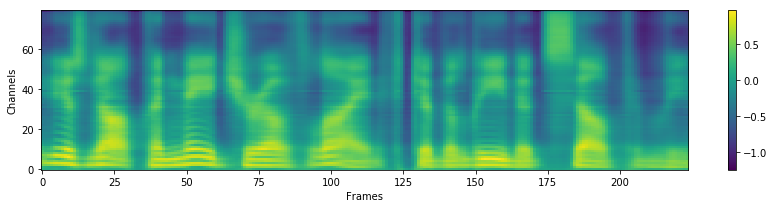

In [19]:
%matplotlib inline

import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(out[0].detach().cpu(), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

fig.canvas.draw()

plt.show()

In [25]:
q_a = []
for i,l in enumerate(index_list):
    if i == 2:
        #l = (l*-1+63).long()
        print (l)
    if i==1 :
        #l = (l*-1+31).long()
        print (l)
    if i ==0 :
        l = (l *-1+15).long()
    q_a += [model.quantize[i].embedding(l.detach().cuda().long()).transpose(1,2)]
    #print (q_a[i].size())
out_change = model.decode(q_a,sp_embedding_block, std_block)[-1]

tensor([[11, 24, 18,  7,  1,  8,  4, 26, 16, 30, 15,  1, 19, 24, 14, 23, 20, 25,
         25, 25,  0, 13,  7, 28,  2,  0,  3,  5, 11, 11, 14, 31, 10,  5,  7,  0,
         28, 10,  1,  1, 11, 18,  7, 31, 10, 17, 30,  0,  6, 16, 13,  1, 23, 26,
         12, 11]])
tensor([[ 4, 24, 52, 37, 22, 40, 20, 24, 49, 11, 37,  9, 27, 37, 62, 41, 23, 58,
         54, 38, 50, 51, 41, 60, 47, 22, 29, 29]])


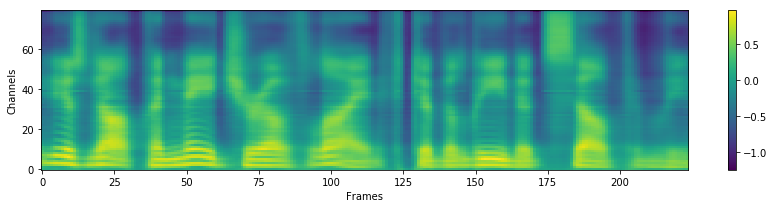

In [21]:
%matplotlib inline

import matplotlib.pylab as plt
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(out[0].detach().cpu(), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

fig.canvas.draw()

plt.show()

In [26]:
out = (out*50 -50)/25
out_change =  (out_change*50 -50)/25
dec = vocoder.inverse(out)[0]
dec_change = vocoder.inverse(out_change)[0]

In [27]:
import IPython.display as ipd
ipd.Audio(dec.cpu(),autoplay=False, rate=22050)

In [28]:
ipd.Audio(dec_change.cpu(),autoplay=False, rate=22050)

In [283]:
import pyworld as pw
import librosa
import numpy as np
x, fs = librosa.load('/home/ericwudayi/nas189/homes/ericwudayi/VCTK-Corpus/wav48/p225/p225_001.wav', dtype=np.float64)
print (fs)

22050


In [308]:
from librosa.filters import mel as librosa_mel_fn
f0, sp, ap = pw.wav2world(x, fs)    # use default options
coded_sp = pw.code_spectral_envelope(sp, fs, 80)
print (coded_sp.shape)
fftlen = pw.get_cheaptrick_fft_size(fs)
decoded_sp = pw.decode_spectral_envelope(coded_sp, fs, fftlen)

y = pw.synthesize(f0, decoded_sp, ap, fs, pw.default_frame_period)
print (y.shape)

(411, 80)
(45312,)


In [309]:
import IPython.display as ipd
ipd.Audio(y,autoplay=False, rate=22050)

In [310]:
ipd.Audio(mel_audio[0].cpu().detach(),autoplay=False, rate=22050)

In [311]:
print (f0.shape, sp.shape, ap.shape)
#print (sp[604,:])

(411,) (411, 513) (411, 513)


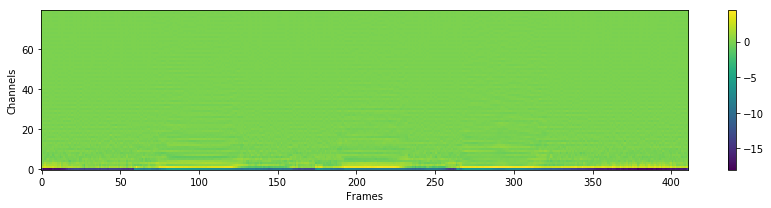

In [314]:
%matplotlib inline
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow((coded_sp.T), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

fig.canvas.draw()

plt.show()

In [83]:
print (f0)

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         191.55650573 186.4855487  221.36997933 224.34487751
 235.78244709 232.77003733 223.55055296 224.96603887 235.36729933
 225.8897564  228.47817284 230.47254991 229.82486004 229

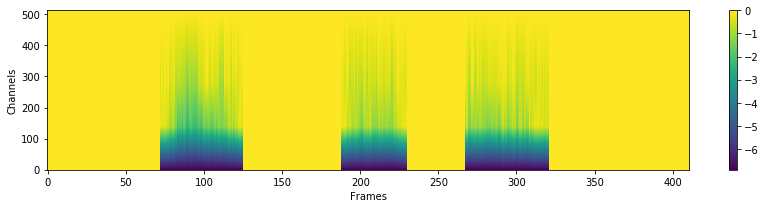

In [82]:
%matplotlib inline
import matplotlib.pylab as plt
#sp[sp>0.05] = 0.05
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(np.log(ap.T), aspect="auto", origin="lower",
               interpolation='none')
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

fig.canvas.draw()

plt.show()

In [300]:
import pickle
with open("/home/ericwudayi/nas189/homes/ericwudayi/VCTK-Corpus/mel_world/mel.melgan/wav48_p279_p279_406.npy", 'rb') as pickle_file:
    m = pickle.load(pickle_file)
m[2].shape

(502, 513)